# Import Libaries and Dataset

In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras import layers

# Creeating Features and Captions Dcitionary

In [2]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download('adityajn105/flickr8k')

print('Path to dataset files:', path)
import shutil

# Define source and destination paths
source_path = '/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1'
destination_path = '/content/flickr8k'

shutil.move(source_path, destination_path)

!ls /content/flickr8k

100%|██████████| 1.04G/1.04G [00:48<00:00, 23.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1
captions.txt  Images


In [ ]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    pooling='avg'
)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
id_to_features = {}

for name in tqdm(os.listdir("/content/flickr8k/Images")):
    img = img_to_array(load_img("/content/flickr8k/Images/" + name, target_size=(224,224)))
    img = preprocess_input(img.reshape((1, img.shape[0], img.shape[1], img.shape[2])))
    feature = resnet50.predict(img, verbose=0)
    id_to_features[name.split('.')[0]]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
id_to_features['587604325_af5d6df679'].shape

(1, 2048)

In [ ]:
len(id_to_features)

8091

In [ ]:
from itertools import islice

id_to_captions = {}

with open("/content/flickr8k/captions.txt", 'r') as f:
    for i, line in enumerate(f):
        if i==0:
            continue
        tokens = line.split('.jpg,')
        id, caption = tokens[0], tokens[1]
        if id not in id_to_captions:
            id_to_captions[id] = []
        id_to_captions[id].append(caption)

In [ ]:
len(id_to_captions)

8091

In [ ]:
id_to_captions['587604325_af5d6df679']

['A curly haired dog tries to bite another dog wearing a green and orange collar .\n',
 'One brown dog is bearing its teeth at another brown dog with a green collar in a park .\n',
 'Two brown dogs playing .\n',
 '"Two dogs , one with its mouth open ."\n',
 'Two golden dogs playing with one another\n']

# Preprocessing and Tokenizing

In this part you need to clean the captions text in order to use Tokenizer.

In [ ]:
# preprocess caption texts
def preprocessing(cap_id):
  for hash, caption in cap_id.items():
    for index in range(len(caption)):
      text: str = caption[index]
      text = text.lower().replace('"', '').replace('[^A-Za-z\s]', '').replace('\s+', ' ')
      text = ' '.join( [word for word in text.split() if len(word)>1] )
      caption[index] = '<start> ' + text + ' <end>'

## Data Generator

In [ ]:
# craete data generator
def data_generator(id_to_captions, id_to_features, tokenizing, max, length, batch_size, hash):
    features, sequence, target, n = list(), list(), list(), 0
    while(True):
        for index in hash:
            n += 1
            for caption in id_to_captions[index]:
                sq = tokenizing.texts_to_sequences([caption])[0]
                for i in range(1, len(sq)):
                    x, y = sq[:i], sq[i]
                    features.append(id_to_features[index][0])
                    sequence.append(pad_sequences([x], maxlen=max)[0])
                    target.append(to_categorical([y],num_classes = length)[0])
            if batch_size == n + 1:
                features, sequence, target = np.array(features), np.array(sequence), np.array(target)
                yield [features, sequence], target

                features, sequence, target, n = list(), list(), list(), 0



## Model

In [ ]:
# define the model
class RecursiveModel():
    def __init__(self, max, length):
        in1 = layers.Input(shape=(2048, ))
        in2 = layers.Input(shape = (max,))

        ftr1 = layers.Dropout(0.3)(in1)
        ftr2 = layers.Dense(256, activation="relu")(ftr1)
        ftr3 = layers.Dense(128, activation="relu")(ftr2)

        sq1 = layers.Embedding(length, 256, mask_zero = True)(in2)
        sq2 = layers.Dropout(0.3)(sq1)
        sq3 = layers.LSTM(256)(sq2)
        sq4 = layers.Dense(128, activation="relu")(sq3)

        fn1 = layers.add([ftr3, sq4])
        fn2 = layers.BatchNormalization()(fn1)
        fn3 = layers.Dense(128, activation = "relu")(fn2)
        fn4 = layers.Dense(length, activation = "softmax")(fn3)

        mdl = Model(inputs = [in1,in2], outputs = fn4)
        mdl.compile(loss = "categorical_crossentropy", optimizer="adam")

        self.model = mdl

# Train

Train the model and plot loss for training data.

In [ ]:
# train the model

epochs, batch_size, all = 20, 16, []
sp = int(len(list(id_to_features.keys())) * 0.9)
tr_hash, tst_hash = list(id_to_features.keys())[:sp], list(id_to_features.keys())[sp:]

for index in id_to_captions:
    for caption in id_to_captions[index]:
        all.append(caption)

tokenizing = Tokenizer()
tokenizing.fit_on_texts(all)
length, max = len(tokenizing.word_index) + 1, np.max([len(cp.split()) for cp in all])

for index in range(epochs):
    dt_gen = data_generator(id_to_captions, id_to_features, tokenizing, max, length, batch_size, tr_hash)
    tr_model = RecursiveModel(max, length)
    tr_model.model.fit(dt_gen, epochs=1, steps_per_epoch= (len(tr_hash) // batch_size))

455/455 [==============================] - 79s 165ms/step - loss: 4.9679


## Test

In this part evaluate the model and generate caption for 10 of test images. For evaluation use "bert-base-uncased" pretrained model and calculate similarity for the predicted sentence of model and real captions.
Show 3 of the images and predictied samples.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.4 MB/s eta 0:00:00


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The caption created for picture 2607099736_8681f601d9
 predicted caption: <start> two men in the orange player in the ball <end> vs true caption: <start> gymnast is bending over on yellow mat on the grass <end>
 Similarity value is: 0.5506725008844987
The caption created for picture 1526325728_74eb4153d8
 predicted caption: <start> dog is running in the mouth <end> vs true caption: <start> grey colored dog walks in wet sand at beach <end>
 Similarity value is: 0.841449582072026
The caption created for picture 2553188198_da1123a723
 predicted caption: <start> dog is running in the mouth <end> vs true caption: <start> black dog crosses puddle of water with ball in its mouth while brown dog looks the other way <end>
 Similarity value is: 0.5497026180075222
The caption created for picture 2715289538_d77c8d0a85
 predicted caption: <start> boy is in the blue and girl is is in the <end> vs true caption: <start> boy is trying to blow huge bubble using giant metal ring <end>
 Similarity value i

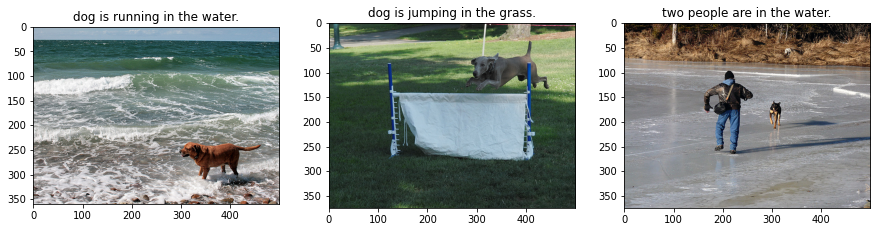

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",)
model = AutoModel.from_pretrained("bert-base-uncased",output_hidden_states=True)


def get_embeddings(text,token_length):
    return tokenizer.encode(text, max_length=token_length, padding='max_length')

def calculate_similarity(text1,text2,token_length=20):
    similar = cosine_similarity(np.array(get_embeddings(text1,token_length)).reshape(1, -1), np.array(get_embeddings(text2,token_length)).reshape(1, -1))
    return similar[0][0]

def predit_capton(model, features, tokenizer, max):
    result = '<start>'
    for index in range(max):
        sequence = tokenizer.texts_to_sequences([result])[0]
        sequence = pad_sequences([sequence], maxlen=max)
        prediction = model.predict([features, sequence], verbose=0)
        prediction = np.argmax(prediction)
        wd = tokenizer.sequences_to_texts([[prediction]])[0]
        if wd is None: break
        result += ' ' + wd
        if wd == 'end': break
    return result

for index in range(10):
    key = np.random.choice(tst_hash)
    pre_cap, true_cap = predit_capton(tr_model.model, id_to_features[key], tokenizing, max).replace("end", "<end>"), id_to_captions[key][0]
    output = "The caption created for picture " + str(key) + "\n predicted caption: " + pre_cap + " vs true caption: " + true_cap + "\n Similarity value is: " + str(calculate_similarity(pre_cap, true_cap, max))
    print(output)

fig = plt.figure(figsize=(15, 5))
for index in range(3):
    hash_key = np.random.choice(tst_hash)
    img, caption = Image.open(f"/content/flicker8k/Images/{hash_key}.jpg"), predit_capton(tr_model.model, id_to_features[hash_key], tokenizing, max).replace("<start> ", "").replace(" end", ".")
    ax = fig.add_subplot(1, 3, index + 1)
    ax.imshow(img)
    ax.set_title(caption)